Adding PDFs
====

Investigation into using a PDF to describe the combination of multiple distributions.

In [1]:
# Just some boilerplate code

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (10.0, 8.0)

rng = np.random.default_rng()
pdf_domain = (-3, 7)
pdf_range = (0, 1.0)


def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points

Consider three distributions and their sum:

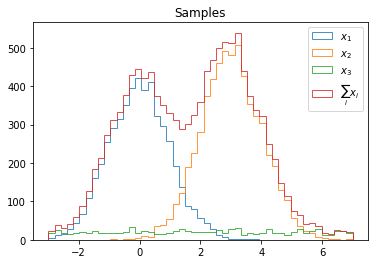

In [2]:
# Define three distributions - these aren't normalised
fcn1 = lambda x: 1.2 * norm.pdf(x, loc=0, scale=1)
fcn2 = lambda x: 0.9 * norm.pdf(x, loc=3, scale=1)
fcn3 = lambda x: 0.5 * int(pdf_domain[0] < x < pdf_domain[1])

# Generate different numbers of points for each distribution
N1, N2, N3 = 5000, 6000, 1000
x1 = sample(N1, fcn1)
x2 = sample(N2, fcn2)
x3 = sample(N3, fcn3)

# Plot histograms
kw = {"histtype": "step", "bins": np.linspace(*pdf_domain, 50), "alpha": 0.8}
plt.hist(x1, **kw, label=r"$x_1$")
plt.hist(x2, **kw, label=r"$x_2$")
plt.hist(x3, **kw, label=r"$x_3$")
plt.hist(np.concatenate((x1, x2, x3)), **kw, label=r"$\sum_ix_i$")
plt.title("Samples")
plt.legend()
plt.show()

What PDF describes the combination $X = x_1 + x_2 + x_3$?

We might expect the combined PDF $p(x)$ to be a linear combination of the underlying PDFs, where the contribution from each is proportional to the statistics:

$p(x) \stackrel{?}{=}  N_1p_1(x) + N_2p_2(x) + N_3p_3(x)$

However, this does not work in the case where the underlying PDFs are not correctly normalised (and so aren't technically PDFs):

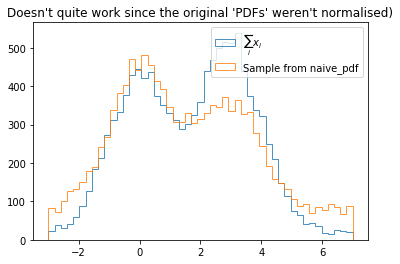

In [3]:
Ntot = N1 + N2 + N3
naive_pdf = lambda x : N1 / Ntot * fcn1(x) + N1 / Ntot * fcn2(x) + N3 / Ntot * fcn3(x)

naive_sample = sample(Ntot, naive_pdf)
plt.hist(np.concatenate((x1, x2, x3)), **kw, label=r"$\sum_ix_i$")
plt.hist(naive_sample, **kw, label="Sample from naive_pdf")
plt.legend()
plt.title("Doesn't quite work since the original 'PDFs' weren't normalised)")
plt.show()

Instead, hypothesize that the combined PDF is:

$p(x) = I_1p_1(x) + I_2p_2(x) + I_3p_3(x)$

Where:

$I_j = \sum_{i=0}^{N_j}\frac{1}{p_j(x_i)}$


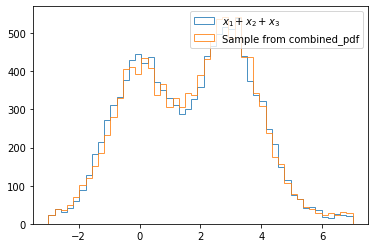

In [4]:
I1 = 0
I2 = 0
I3 = 0

# Iterate over all of the points
for p in x1:
    I1 += 1 / fcn1(p)
for p in x2:
    I2 += 1 / fcn2(p)
for p in x3:
    I3 += 1 / fcn3(p)

# Scale the integrals to something more sensible
scale_factor = I1 + I2 + I3
I1 /= scale_factor
I2 /= scale_factor
I3 /= scale_factor

combined_pdf = lambda x: I1 * fcn1(x) + I2 * fcn2(x) + I3 * fcn3(x)

# Generate a sample from the combined PDF
x4 = sample(Ntot, combined_pdf)

plt.hist(np.concatenate((x1, x2, x3)), **kw, label=r"$x_1+x_2+x_3$")
plt.hist(x4, **kw, label=r"Sample from combined_pdf")
plt.legend()
plt.show()

$\uparrow$ This looks right now.

Let's also plot the (un-normalised) PDFs:

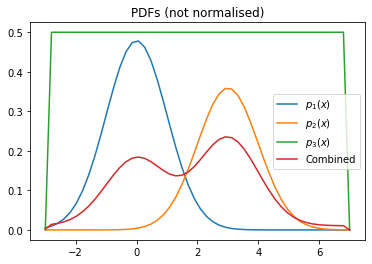

In [6]:
# Plot PDFs
points = np.linspace(*pdf_domain)
dist1 = [fcn1(x) for x in points]
dist2 = [fcn2(x) for x in points]
dist3 = [fcn3(x) for x in points]

combined_dist = [combined_pdf(x) for x in points]

plt.plot(points, dist1, label=r"$p_1(x)$")
plt.plot(points, dist2, label=r"$p_2(x)$")
plt.plot(points, dist3, label=r"$p_3(x)$")
plt.plot(points, combined_dist, label=r"Combined")
plt.title("PDFs (not normalised)")
plt.legend()

plt.show()